# IoT Planning 

**Input**: data from telco's customers with demographic, services and account information.

**Output**: flask application with form to be filled with customer's information. The application should return with the prediction result if the customer will or will not churn in that month.

**Tasks**:
- data description
- end-to-end solution
- metrics definition
- data cleaning
- check the unbalency
- feature engineering
- eda
- data preparation
- feature selection
- ml models
- hyperparameters fine tuning
- deploy

# 0.0 Imports

In [2]:
from IPython.core.display      import HTML
from pycaret.classification    import *
from scikitplot                import metrics         as mt
from sklearn                   import model_selection as ms
from sklearn                   import preprocessing   as pp
from sklearn                   import metrics         as m
from keras                     import models          as ml
from keras                     import layers          as l

import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

import inflection

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 1.0 Data Description

In [5]:
df1 = df_train.copy()

## 1.1 Data Dimension

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 5634
Number of columns: 21


## 1.2 Rename Columns

In [7]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
            'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
            'MonthlyCharges', 'TotalCharges', 'Churn']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df1.columns = new_cols

In [8]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df_test.columns = new_cols

## 1.3 Data Types

In [9]:
df1.dtypes

id                     int64
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure               float64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                  int64
dtype: object

## 1.4 Check N/A

In [10]:
df1.isna().sum()

id                     0
gender                 0
senior_citizen         0
partner                0
dependents           218
tenure               461
phone_service          0
multiple_lines         0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
contract               0
paperless_billing      0
payment_method        99
monthly_charges        0
total_charges          0
churn                  0
dtype: int64

## 1.5 Check Balanced Data

In [11]:
df1['churn'].value_counts(normalize=True)

0    0.734647
1    0.265353
Name: churn, dtype: float64

## 1.5 Replace N/A

In [12]:
#dependents > replace with No
df1.loc[df1['dependents'].isna(), 'dependents'] = 'No'
#tenure > replace with mean
df1.loc[df1['tenure'].isna(), 'tenure'] = 32.0
#payment_method > replace with "Not specified"
df1.loc[df1['payment_method'].isna(), 'payment_method'] = 'Not specified'

## 1.6 Change Data Types

In [13]:
df1['total_charges'] = pd.to_numeric(df1['total_charges'], errors='coerce')

In [14]:
df_test['total_charges'] = pd.to_numeric(df_test['total_charges'], errors='coerce')

## 1.7 Statistics Description

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

## 1.7.1  Numerical Attributes 

In [22]:
#central tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion (std, min, max, range, skew, kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#final dataset
num_desc = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_desc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,7043.00,7042.0,3530.313454,3525.50,2036.014395,0.000004,-1.202118
1,senior_citizen,0.00,1.00,1.0,0.158679,0.00,0.365377,1.868818,1.493010
2,tenure,0.00,72.00,72.0,32.305644,32.00,23.439299,0.259980,-1.229054
3,monthly_charges,18.25,118.75,100.5,64.626438,70.25,30.019141,-0.216087,-1.257425
4,total_charges,18.80,8684.80,8666.0,2273.513811,NaN,2258.183227,0.970766,-0.205691
5,churn,0.00,1.00,1.0,0.265353,0.00,0.441521,1.063185,-0.869947


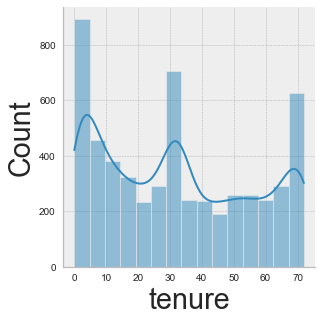

In [21]:
a = sns.displot(data=df1, x='tenure', kde=True);
plt.show();

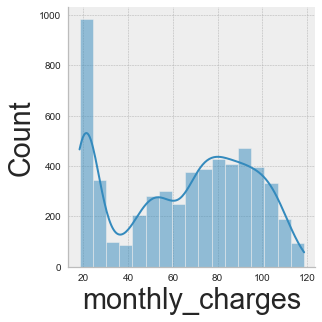

In [23]:
a = sns.displot(data=df1, x='monthly_charges', kde=True);
plt.show();

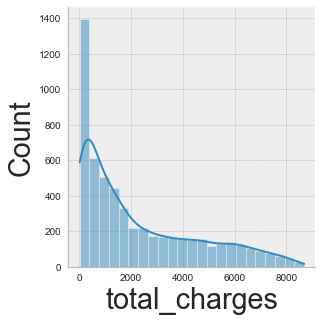

In [24]:
a = sns.displot(data=df1, x='total_charges', kde=True);
plt.show();

## 1.7.2 Categorical Attributes 

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender               2
partner              2
dependents           2
phone_service        2
multiple_lines       3
internet_service     3
online_security      3
online_backup        3
device_protection    3
tech_support         3
streaming_tv         3
streaming_movies     3
contract             3
paperless_billing    2
payment_method       5
dtype: int64

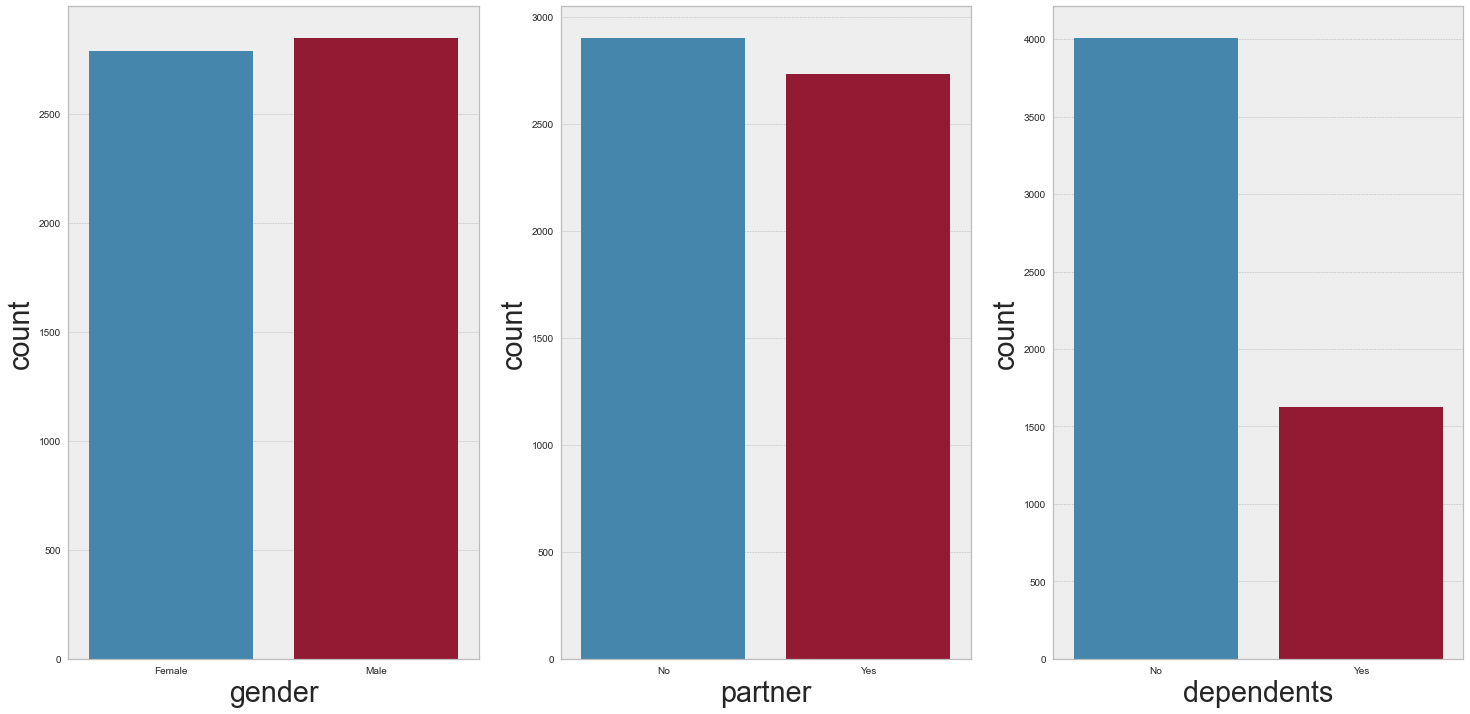

In [27]:
plt.subplot(1, 3, 1)
sns.countplot(df1['gender'])

plt.subplot(1, 3, 2)
sns.countplot(df1['partner'])

plt.subplot(1, 3, 3)
sns.countplot(df1['dependents'])
plt.show()

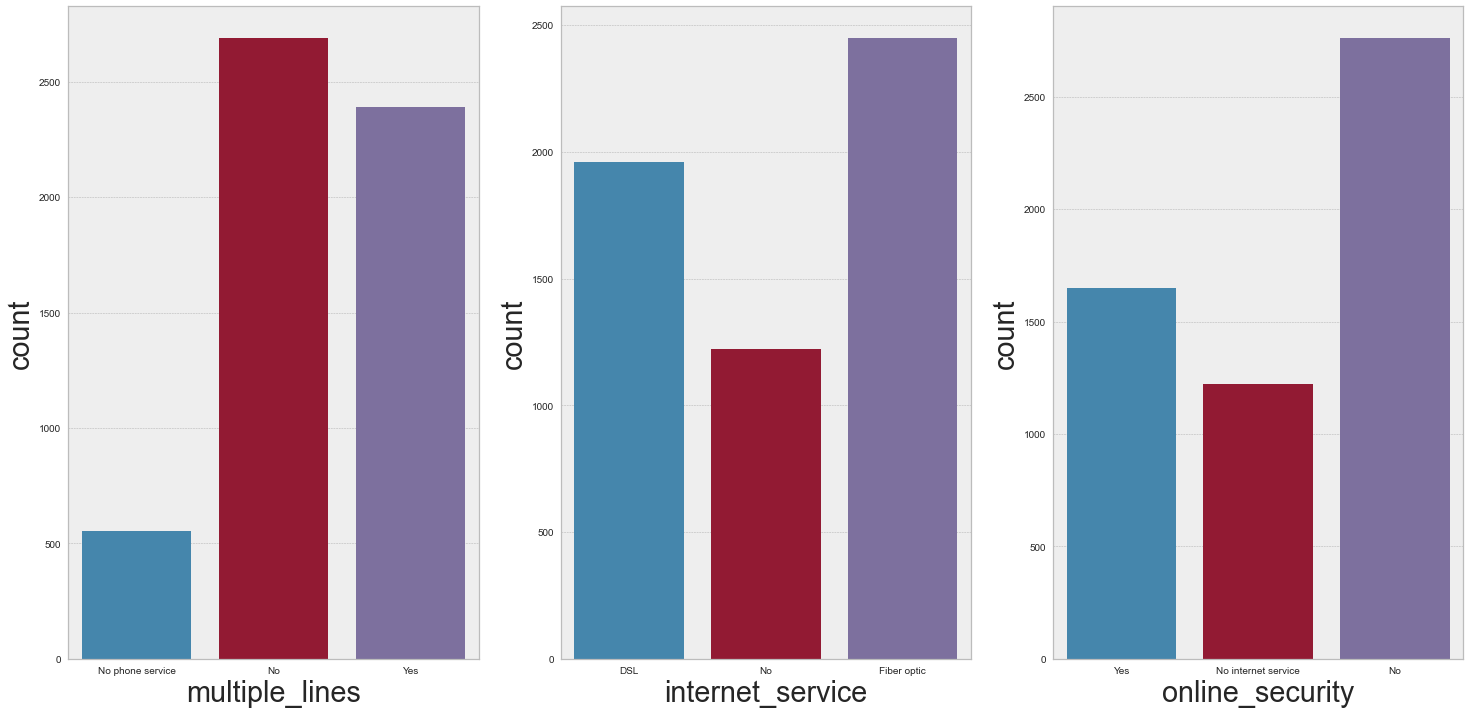

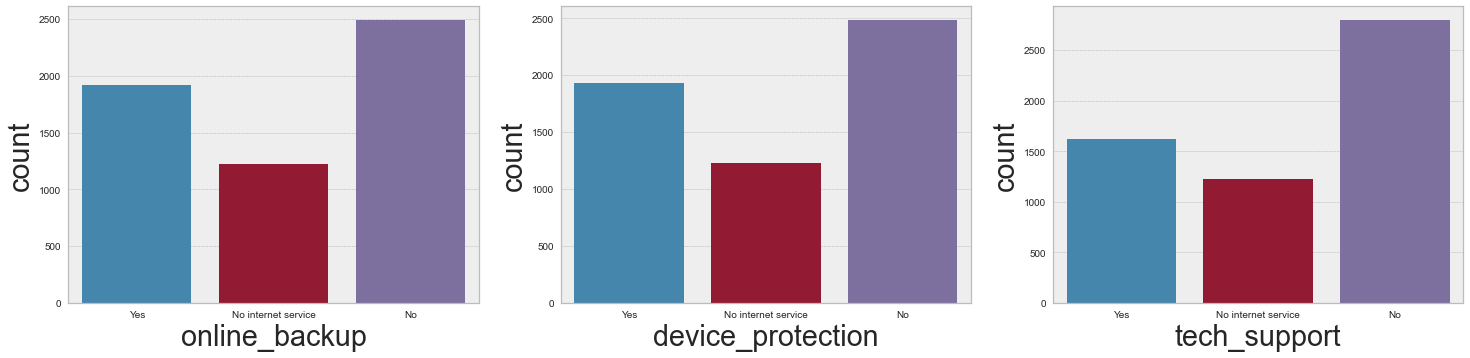

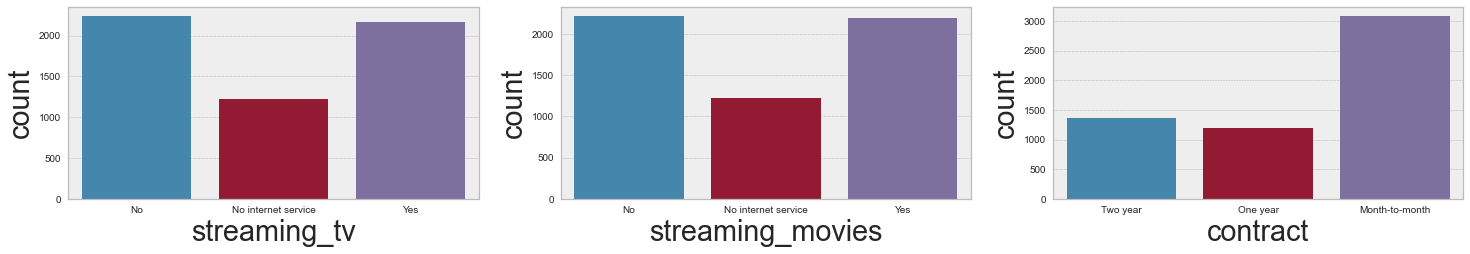

In [32]:
plt.subplot(1, 3, 1)
sns.countplot(df1['multiple_lines'])

plt.subplot(1, 3, 2)
sns.countplot(df1['internet_service'])

plt.subplot(1, 3, 3)
sns.countplot(df1['online_security'])
plt.show()

plt.subplot(2, 3, 1)
sns.countplot(df1['online_backup'])

plt.subplot(2, 3, 2)
sns.countplot(df1['device_protection'])

plt.subplot(2, 3, 3)
sns.countplot(df1['tech_support'])
plt.show()

plt.subplot(3, 3, 1)
sns.countplot(df1['streaming_tv'])

plt.subplot(3, 3, 2)
sns.countplot(df1['streaming_movies'])

plt.subplot(3, 3, 3)
sns.countplot(df1['contract'])
plt.show()

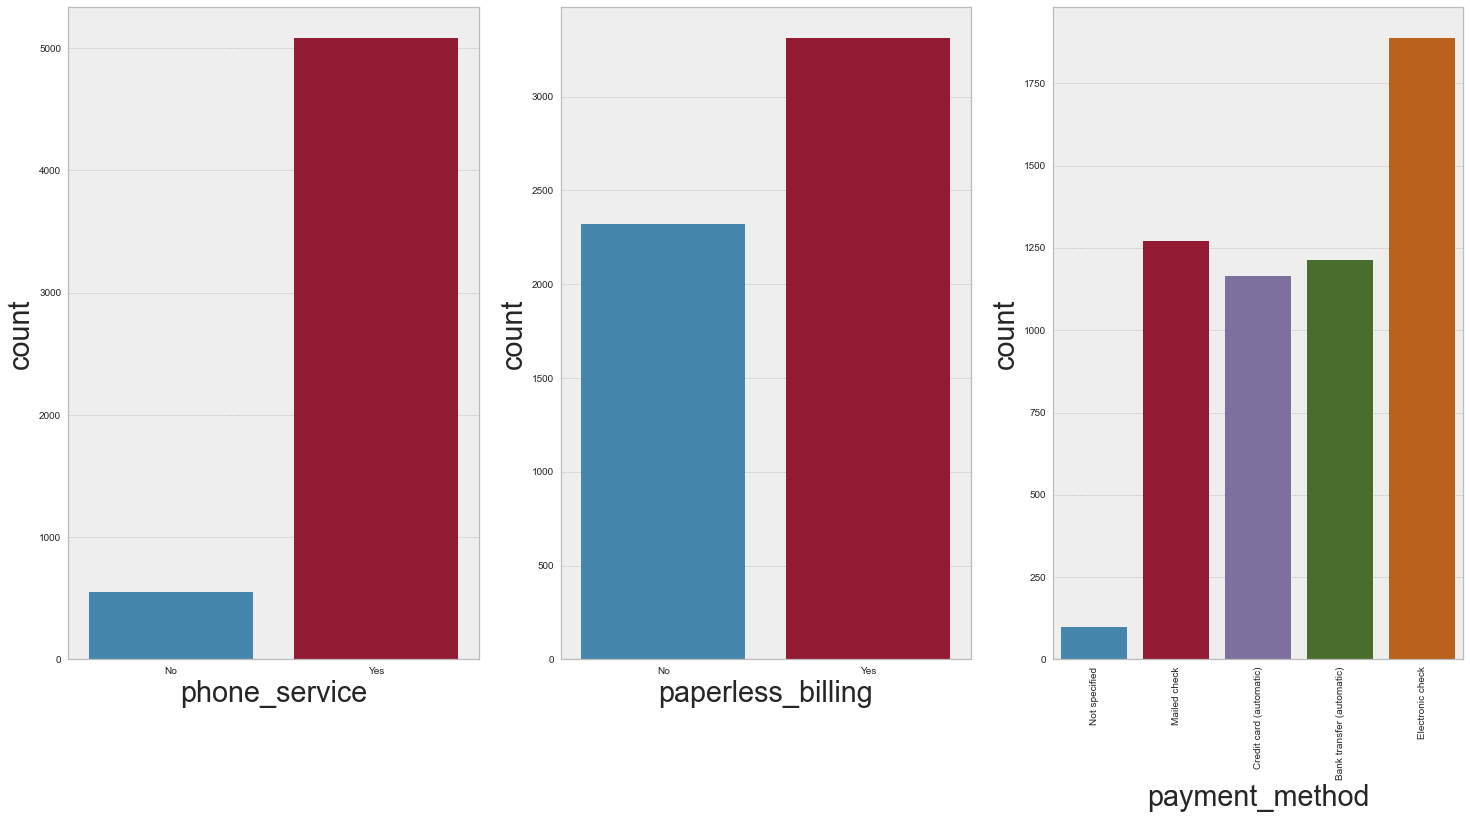

In [34]:
plt.subplot(1, 3, 1)
sns.countplot(df1['phone_service'])

plt.subplot(1, 3, 2)
sns.countplot(df1['paperless_billing'])

plt.subplot(1, 3, 3)
sns.countplot(df1['payment_method'])
plt.xticks(rotation=90)
plt.show()

# Model w/ Pycaret

In [ ]:
setup(data=df1, target='churn')

In [ ]:
best_model = compare_models(n_select=5)

In [ ]:
len(df1.loc[df1['churn']==0])/len(df1)

In [ ]:
t = tune_model(best_model[0])

In [ ]:
final_model = finalize_model(t)

In [ ]:
predict = predict_model(final_model, df_test)
predict

In [ ]:
len(predict.loc[predict['Label']==0])

In [ ]:
len(predict.loc[predict['Label']==1])

# Model w/ Neural Network MLP

In [ ]:
df2 = df1.copy()
df2_dummy = pd.get_dummies(df2.drop(['id', 'churn'], axis=1))
df2 = pd.concat([df2[['id', 'churn']], df2_dummy], axis=1)

In [ ]:
X = df2.drop(['id', 'churn'], axis=1)
y = df2['churn'].copy()

In [ ]:
#training and test dataset
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
y_train_nn = y_train.values.reshape(-1, 1)

In [ ]:
#model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
model.fit(X_train, y_train_nn, epochs=100)